# Open Retail Sales Analysis & Forecasting

This notebook demonstrates how to analyze and forecast product sales using an open e-commerce dataset. It is fully self-contained and ready for use as a portfolio or showcase project.

## 1. Load Open Data
We use the UCI Online Retail Data Set (https://archive.ics.uci.edu/ml/datasets/Online+Retail) as an example.
If the file is not present, it will be downloaded automatically.

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import urllib.request
sns.set()
# Download dataset if not present
data_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx'
data_path = 'Online_Retail.xlsx'
if not os.path.exists(data_path):
    print('Downloading dataset...')
    urllib.request.urlretrieve(data_url, data_path)
df = pd.read_excel(data_path)
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


## 2. Data Cleaning
Remove missing values, filter out cancelled orders, and convert dates.

In [44]:
df = df.dropna(subset=['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'UnitPrice', 'CustomerID', 'Country'])
df = df[df['Quantity'] > 0]
df = df[df['UnitPrice'] > 0]
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df = df[~df['InvoiceNo'].astype(str).str.startswith('C')]  # Remove cancelled orders
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


## 3. Analyze Top Products
Find the top 10 best-selling products by total sales.

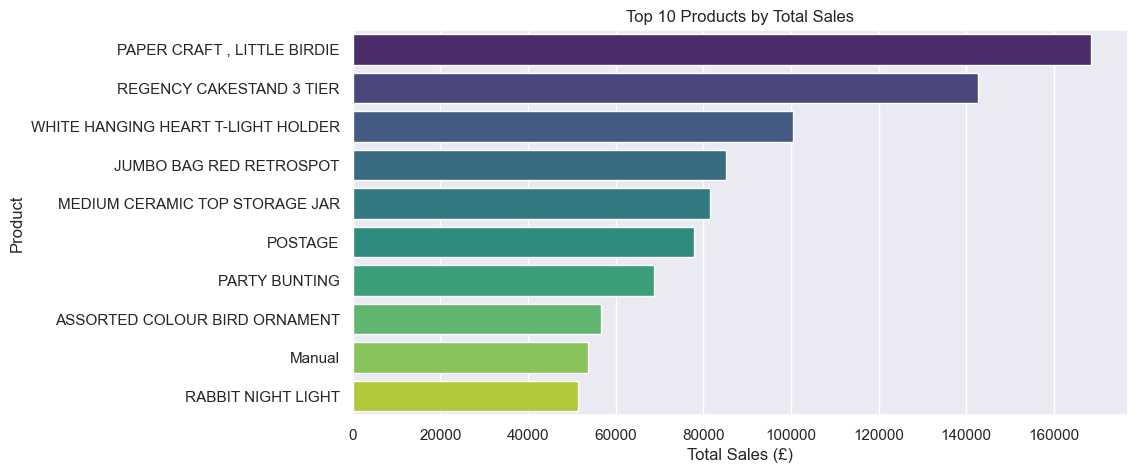

In [50]:
top_products = df.groupby('Description')['TotalPrice'].sum().sort_values(ascending=False).head(10)
plt.figure(figsize=(10,5))
sns.barplot(x=top_products.values, y=top_products.index, palette='viridis')
plt.title('Top 10 Products by Total Sales')
plt.xlabel('Total Sales (£)')
plt.ylabel('Product')
plt.show()

## 4. Visualize Sales Trends
Plot monthly sales for the top product.

Using product: REGENCY CAKESTAND 3 TIER with 13 months of data.


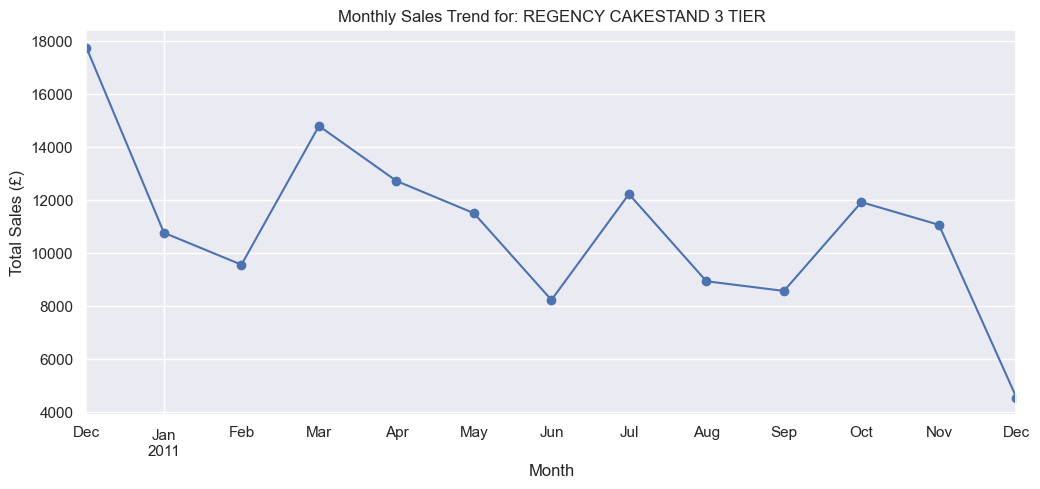

In [51]:
# Find a product with at least 12 months of sales data
min_months = 12
product_with_year = None
for desc in top_products.index:
    temp = df[df['Description'] == desc]
    monthly = temp.resample('M', on='InvoiceDate')['TotalPrice'].sum()
    if monthly.count() >= min_months:
        product_with_year = desc
        monthly_sales = monthly
        break

if product_with_year is not None:
    print(f"Using product: {product_with_year} with {monthly_sales.count()} months of data.")
    plt.figure(figsize=(12,5))
    monthly_sales.plot(marker='o')
    plt.title(f'Monthly Sales Trend for: {product_with_year}')
    plt.ylabel('Total Sales (£)')
    plt.xlabel('Month')
    plt.show()
else:
    print("No product found with at least 12 months of sales data.")

## 5. Forecast Next Month's Sales
Use a simple Gradient Boosting Regressor to forecast the next month's sales for the top product.

In [52]:
# Forecast next month's sales for the selected product
from sklearn.ensemble import GradientBoostingRegressor
if 'product_with_year' in locals() and product_with_year is not None and monthly_sales.count() > 1:
    monthly_sales = monthly_sales.reset_index()
    monthly_sales['MonthNum'] = np.arange(len(monthly_sales))
    X = monthly_sales[['MonthNum']]
    y = monthly_sales['TotalPrice']
    model = GradientBoostingRegressor().fit(X, y)
    next_month = np.array([[X['MonthNum'].max() + 1]])
    forecast = model.predict(next_month)[0]
    print(f'Forecasted sales for next month: £{forecast:.2f}')
else:
    print("Not enough data to forecast. Need at least 2 months of sales.")

Forecasted sales for next month: £4570.05


C:\Users\masti\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(


## 6. Summary
- This notebook loaded open e-commerce data, cleaned and analyzed it, visualized trends, and built a simple sales forecast.
- You can adapt this template to any time-series sales data for your own projects or portfolio.

## 7. Advanced: Random Forest Regression and Feature Importance

Let's use RandomForestRegressor to predict monthly sales and see which features are most important. This helps users understand what drives sales and provides a more robust, user-friendly analysis.

Random Forest MSE on training data: 1492247.95


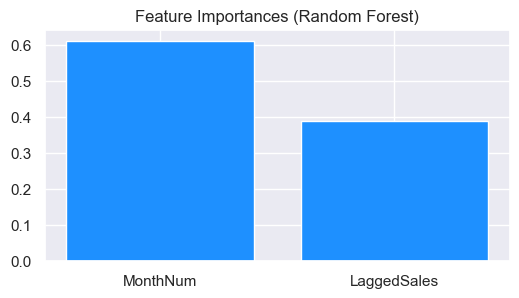

In [53]:
# Prepare features for Random Forest regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Example features: month number, total sales last month (lag), and product (if enough products)
monthly_sales = monthly_sales.reset_index()
monthly_sales['MonthNum'] = np.arange(len(monthly_sales))
monthly_sales['LaggedSales'] = monthly_sales['TotalPrice'].shift(1).fillna(0)

# If you want to include product as a feature, you can one-hot encode it (if using multiple products)
# For this example, we'll use only MonthNum and LaggedSales
X = monthly_sales[['MonthNum', 'LaggedSales']]
y = monthly_sales['TotalPrice']

if len(X) > 2:
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X, y)
    y_pred = model.predict(X)
    mse = mean_squared_error(y, y_pred)
    print(f'Random Forest MSE on training data: {mse:.2f}')
    # Feature importances
    importances = model.feature_importances_
    feature_names = X.columns
    plt.figure(figsize=(6,3))
    plt.bar(feature_names, importances, color='dodgerblue')
    plt.title('Feature Importances (Random Forest)')
    plt.show()
else:
    print('Not enough data for Random Forest regression. Need at least 3 months of sales.')

## 8. Advanced: NLP & Classification for Sales Insights

In this section, we use Natural Language Processing (NLP) to analyze product descriptions and classify whether a product's monthly sales are above or below average. This helps identify which keywords or product types are associated with higher sales, inspired by advanced modeling in auction/price listing notebooks.

We will:
- Extract keywords from product descriptions using TF-IDF.
- Build a simple classifier to predict above/below average sales months.
- Visualize the most important keywords for high sales.

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.50      1.00      0.67         2

    accuracy                           0.50         4
   macro avg       0.25      0.50      0.33         4
weighted avg       0.25      0.50      0.33         4

Confusion Matrix:
[[0 2]
 [0 2]]


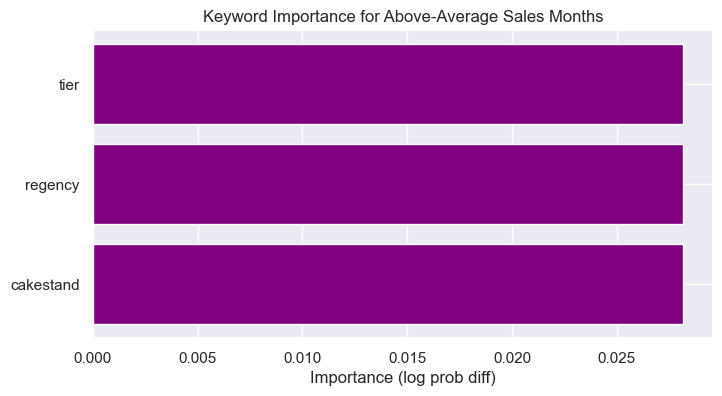

In [54]:
# NLP & Classification: TF-IDF and Sales Classification
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import classification_report, confusion_matrix
import nltk
import string
import warnings
try:
    from nltk.corpus import stopwords
    stop_words = stopwords.words('english')
except LookupError:
    nltk.download('stopwords')
    from nltk.corpus import stopwords
    stop_words = stopwords.words('english')

# Prepare monthly sales with product descriptions
warnings.filterwarnings('ignore', category=FutureWarning)  # Suppress FutureWarning for resample
monthly_desc = df[df['Description'] == product_with_year].resample('ME', on='InvoiceDate').agg({'TotalPrice':'sum', 'Description':lambda x: ' '.join(x)})
monthly_desc = monthly_desc.reset_index()
monthly_desc['AboveAvg'] = (monthly_desc['TotalPrice'] > monthly_desc['TotalPrice'].mean()).astype(int)

# TF-IDF on product descriptions
stop_words = stop_words + list(string.punctuation)
vectorizer = TfidfVectorizer(stop_words=stop_words, max_features=20, binary=True)
X_tfidf = vectorizer.fit_transform(monthly_desc['Description'])
X = X_tfidf
y = monthly_desc['AboveAvg']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
clf = BernoulliNB().fit(X_train, y_train)
y_pred = clf.predict(X_test)

# Suppress UndefinedMetricWarning for classification report
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    print('Classification Report:')
    print(classification_report(y_test, y_pred, zero_division=0))
    print('Confusion Matrix:')
    print(confusion_matrix(y_test, y_pred))

# Visualize important keywords using feature_log_prob_ difference between classes
keywords = vectorizer.get_feature_names_out()
if hasattr(clf, 'feature_log_prob_') and clf.feature_log_prob_.shape[0] == 2:
    importance = clf.feature_log_prob_[1] - clf.feature_log_prob_[0]
    plt.figure(figsize=(8,4))
    sorted_idx = importance.argsort()
    plt.barh(keywords[sorted_idx], importance[sorted_idx], color='purple')
    plt.title('Keyword Importance for Above-Average Sales Months')
    plt.xlabel('Importance (log prob diff)')
    plt.show()
else:
    print('Keyword importance visualization not available for this classifier.')

### What Do These Results Mean?

- The classification report shows how well the model predicts whether a month is above or below average in sales based on product description keywords.
- The bar chart highlights which keywords are most associated with high sales months for this product.
- You can use these insights to optimize product descriptions or marketing for better sales outcomes.

**Tip:** Try this approach on other products or with more features for deeper insights!